In [97]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

import librosa as librosa
import matplotlib.pyplot as plt

import numpy as  np


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


In [98]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")
# path2 = kagglehub.dataset_download("ejlok1/surrey-audiovisual-expressed-emotion-savee")
# path3 = kagglehub.dataset_download("ejlok1/cremad")
# path4 = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

# print(f"Path to dataset files:{path} , {path2}, {path3}, {path4}")

In [99]:
# Paths for data.
Ravdess = "data/ravdess-emotional-speech-audio/versions/1/"
Crema = "data/cremad/versions/1/AudioWAV/"
Tess = "data/toronto-emotional-speech-set-tess/versions/1/TessData/"
Savee = "data/surrey-audiovisual-expressed-emotion-savee/versions/1/ALL/"

In [100]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


,Emotions,Path
0,neutral,data/cremad/versions/1/AudioWAV/1037_TIE_NEU_X...
1,fear,data/cremad/versions/1/AudioWAV/1009_TSI_FEA_X...
2,fear,data/cremad/versions/1/AudioWAV/1007_DFA_FEA_X...
3,disgust,data/cremad/versions/1/AudioWAV/1075_TIE_DIS_X...
4,happy,data/cremad/versions/1/AudioWAV/1038_IWW_HAP_X...


In [101]:
Crema_df['Emotions'].replace('fear', 'fearful', inplace=True)
Crema_df['Emotions'].value_counts()

Emotions
fearful    1271
disgust    1271
sad        1271
happy      1271
angry      1271
neutral    1087
Name: count, dtype: int64

In [102]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()


,Emotions,Path
0,neutral,data/toronto-emotional-speech-set-tess/version...
1,neutral,data/toronto-emotional-speech-set-tess/version...
2,neutral,data/toronto-emotional-speech-set-tess/version...
3,neutral,data/toronto-emotional-speech-set-tess/version...
4,neutral,data/toronto-emotional-speech-set-tess/version...


In [103]:
Tess_df['Emotions'].replace('fear', 'fearful', inplace=True)
Crema_df['Path'].iloc[0]

'data/cremad/versions/1/AudioWAV/1037_TIE_NEU_XX.wav'

In [104]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()


,Emotions,Path
0,surprise,data/surrey-audiovisual-expressed-emotion-save...
1,happy,data/surrey-audiovisual-expressed-emotion-save...
2,sad,data/surrey-audiovisual-expressed-emotion-save...
3,surprise,data/surrey-audiovisual-expressed-emotion-save...
4,disgust,data/surrey-audiovisual-expressed-emotion-save...


In [105]:
Savee_df['Emotions'].value_counts()

Emotions
neutral     120
happy        60
surprise     60
sad          60
disgust      60
fear         60
angry        60
Name: count, dtype: int64

In [106]:
"""
File naming convention

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

Vocal channel (01 = speech, 02 = song).

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

Repetition (01 = 1st repetition, 02 = 2nd repetition).
"""


import os
import pandas as pd

emotion_mapping = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

file_dir = "data/ravdess-emotional-speech-audio/versions/1/"

data = []

for actor in os.listdir(file_dir):
    actor_path = os.path.join(file_dir, actor)
    
    if os.path.isdir(actor_path) and actor.startswith("Actor_"):
        actor_number = actor.split("_")[-1]

        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_code = file[6:8]
                emotion = emotion_mapping.get(emotion_code, "unknown")
                #formatted_filename = f"Actor_{actor_number}_{file}"
                data.append({"Emotions": emotion, "Path": actor_path+"/"+file})

ravdess_df = pd.DataFrame(data)

ravdess_df.head()

,Emotions,Path
0,happy,data/ravdess-emotional-speech-audio/versions/1...
1,neutral,data/ravdess-emotional-speech-audio/versions/1...
2,disgust,data/ravdess-emotional-speech-audio/versions/1...
3,fearful,data/ravdess-emotional-speech-audio/versions/1...
4,disgust,data/ravdess-emotional-speech-audio/versions/1...


In [107]:
#remove calm emotion
ravdess_df = ravdess_df[ravdess_df.Emotions != 'calm']
ravdess_df['Emotions'].value_counts()

Emotions
happy        192
disgust      192
fearful      192
angry        192
sad          192
surprised    192
neutral       96
Name: count, dtype: int64

In [108]:
df = pd.concat([ravdess_df,Savee_df,Tess_df,Crema_df], axis=0)

In [109]:
df['Emotions'].replace('fear','fearful',inplace=True)
df['Emotions'].replace('surprise','surprised',inplace=True)
df['Emotions'].value_counts()

Emotions
happy        1923
disgust      1923
fearful      1923
angry        1923
sad          1923
neutral      1703
surprised     652
Name: count, dtype: int64

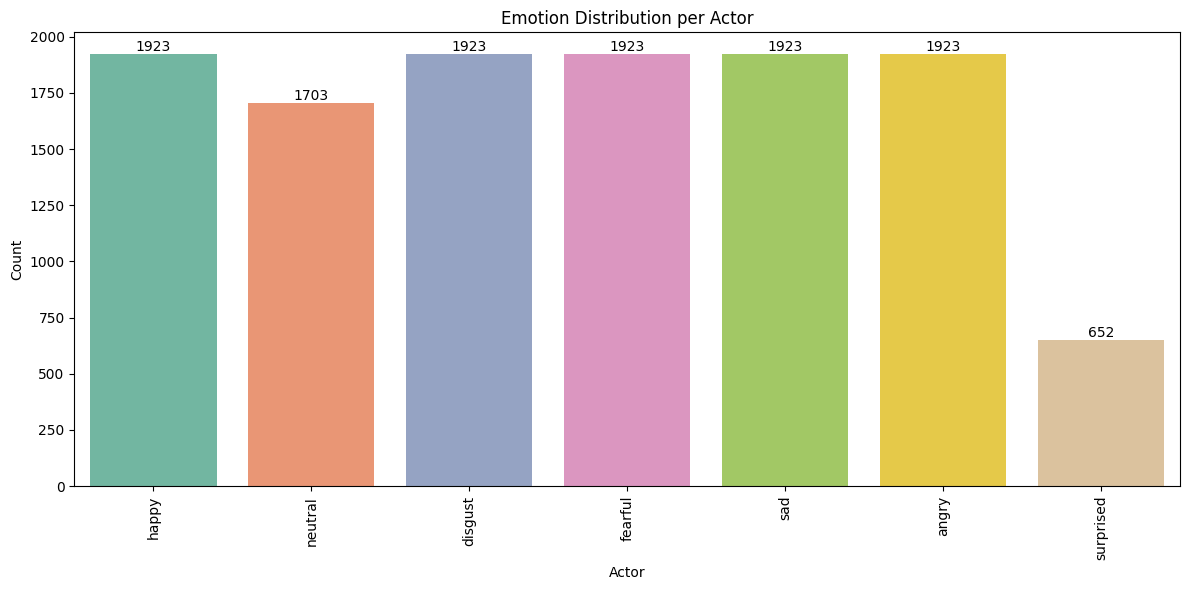

In [220]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='Emotions', palette='Set2')

# Add counts on top of the bars
for container in ax.containers:
    ax.bar_label(container)

plt.title('Emotion Distribution per Actor')
plt.xlabel('Actor')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Extracting waveforms and spectograms

In [110]:
import random 

def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=random.uniform(-2, 2))

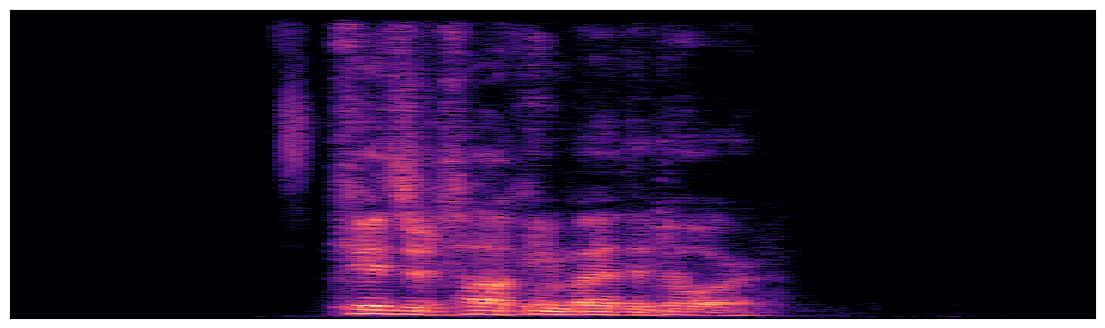

In [111]:
file_path = 'data/ravdess-emotional-speech-audio/versions/1/Actor_01/03-01-01-01-01-01-01.wav'

data, sample_rate = librosa.load(file_path)

x2 = stretch(data)
X = librosa.stft(x2)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14,4))
#librosa.display.waveshow(y=x2, sr=sample_rate)
librosa.display.specshow(data=Xdb)

In [238]:
def extract_features(data, sample_rate):
    result = np.array([])

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc))

    # RMS
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    # Spectral Centroid
    centroid = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, centroid))

    # Spectral Rolloff
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate, roll_percent=0.9).T, axis=0)
    result = np.hstack((result, rolloff))

    # # Spectral Flux
    # spectral_flux = np.sqrt(np.sum(np.diff(stft, axis=1)**2, axis=0))
    # spectral_flux_mean = np.mean(spectral_flux)
    # result = np.hstack((result, spectral_flux_mean))

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)
    
    # # data with noise
    # noise_data = noise(data)
    # res2 = extract_features(noise_data, sample_rate)
    # result = np.vstack((result, res2)) # stacking vertically
    
    # # data with stretching and pitching
    # new_data = stretch(data, sample_rate)
    # data_stretch_pitch = pitch(new_data, sample_rate)
    # res3 = extract_features(data_stretch_pitch, sample_rate)
    # result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [239]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch

emotion_to_num = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "angry": 3,
    "fearful": 4,
    "disgust": 5,
    "surprised": 6
}

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Emotions'], random_state=42)

train_val_set, test_set = [], []

# Loop through train_df with tqdm
print("Processing training data...")
for i in tqdm(range(len(train_df)), desc="Train Set"):
    input_features = torch.from_numpy(get_features(os.path.join(df.iloc[i]['Path'])))
    label = torch.tensor(emotion_to_num[train_df.iloc[i]['Emotions']], dtype=torch.long)
    train_val_set.append((input_features, label))

# Loop through test_df with tqdm
print("Processing testing data...")
for i in tqdm(range(len(test_df)), desc="Test Set"):
    input_features = torch.from_numpy(get_features(os.path.join(df.iloc[i]['Path'])))
    label = torch.tensor(emotion_to_num[test_df.iloc[i]['Emotions']], dtype=torch.long)
    test_set.append((input_features, label))



Processing training data...


Train Set: 100%|██████████| 9576/9576 [06:57<00:00, 22.93it/s]


Processing testing data...


Test Set: 100%|██████████| 2394/2394 [01:51<00:00, 21.45it/s]


In [240]:
train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)

In [258]:
BATCH_SIZE = 128  # <-- Please change this as necessary
NUM_WORKERS = 4  # <-- Use more workers for more CPU threads

#to train the model
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

#to tune the model
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

#to test on unseen data 
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

# Creating the model

In [242]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [243]:
t, f = next(iter(train_loader))
print(t.size())

torch.Size([64, 156])


In [293]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CNN1DModel(nn.Module):
#     def __init__(self):
#         super(CNN1DModel, self).__init__()
        
#         self.conv1 = nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1)
#         self.conv2 = nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1)
        
#         # Linear layer adjusted to 32 * 156 (output size after convs)
#         self.fc1 = nn.Linear(32 * 156, 128)
#         self.fc2 = nn.Linear(128, 7)
            
#         self.relu = nn.ReLU()
    
#     def forward(self, x):
#         # Add channel dimension: [batch_size, 1, 156]
#         if x.dim() == 2:
#             x = x.unsqueeze(1)
        
#         x = self.relu(self.conv1(x))
#         x = self.relu(self.conv2(x))
        
#         # Flatten for the fully connected layer
#         x = x.view(x.size(0), -1)
#         x = self.relu(self.fc1(x))
#         x = self.fc2(x)
#         return x


In [270]:
def train(train_loader, model, optimizer, criterion, n_epochs=10, patience=3):
    model.train()
    losses = []
    lastepoch_loss = float('inf')  # Initialize to a very high value
    patience_counter = 0  # Count epochs without improvement

    for epoch in tqdm(range(n_epochs)):
        batch_losses = []
        correct, total = 0, 0

        for j, data in enumerate(train_loader, 0):  
            x_batch, y_batch = data
            x_batch = x_batch.to(torch.float32).to(device)  # Convert to float32
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            y_predictions = model(x_batch)
            loss = criterion(y_predictions, y_batch)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())

            _, predicted = torch.max(y_predictions, 1)  
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)
        epoch_accuracy = 100 * correct / total

        print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.2f}%")

        # Early stopping check
        if abs(lastepoch_loss - epoch_loss) < 0.001:
            patience_counter += 1
        else:
            patience_counter = 0  # Reset if loss improves
        
        if patience_counter >= patience:
            print(f"Stopping early after {epoch+1} epochs due to lack of improvement.")
            break

        lastepoch_loss = epoch_loss  # Update for next epoch

    return losses

In [295]:
import torch
from torch import nn, optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mymodel = CNN1DModel(156).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mymodel.parameters(), lr=1e-3, weight_decay=1e-3)

RuntimeError: Given groups=1, weight of size [256, 1, 5], expected input[1, 3, 156] to have 1 channels, but got 3 channels instead

In [292]:
epochs = 50

losses = train(train_loader, mymodel, optimizer, criterion, epochs)

  0%|          | 0/50 [00:00<?, ?it/s]


RuntimeError: Given groups=1, weight of size [256, 3, 5], expected input[1, 128, 156] to have 3 channels, but got 128 channels instead

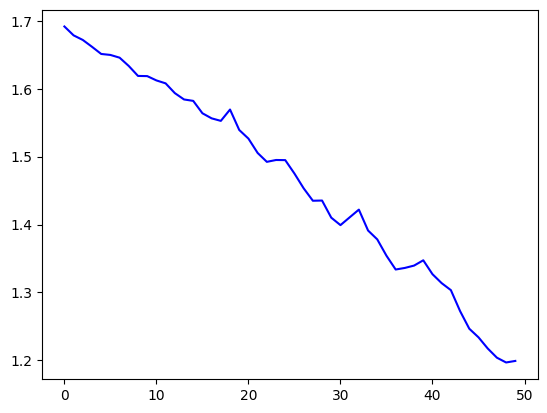

In [285]:
from matplotlib import pyplot as plt 


plt.plot(np.arange(len(losses)), losses, label='Loss Plot', color='blue')

In [286]:
def calculate_accuracy(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    
    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Ensure the input tensor is of type float32
            images = images.float()
            
            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            total += labels.size(0)  # Increment the total number of samples
            correct += (predicted == labels).sum().item()  # Count the correct predictions
            
    accuracy = 100 * correct / total
    return accuracy


In [278]:
def calculate_accuracy(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    total = 0
    correct = 0
    
    with torch.no_grad():  # No need to calculate gradients during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Ensure the input tensor is of type float32
            images = images.float()
            
            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest score
            total += labels.size(0)  # Increment the total number of samples
            correct += (predicted == labels).sum().item()  # Count the correct predictions
            
    accuracy = 100 * correct / total
    return accuracy


In [287]:
accuracy = calculate_accuracy(mymodel, val_loader)
print(f'Val Accuracy: {accuracy:.2f}%')


Val Accuracy: 15.40%


In [288]:
accuracy = calculate_accuracy(mymodel, test_loader)
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 15.79%



Classification Report:
               precision    recall  f1-score   support

     neutral     0.1595    0.1642    0.1618       341
       happy     0.1737    0.1714    0.1725       385
         sad     0.1720    0.1532    0.1621       385
       angry     0.1658    0.1667    0.1662       384
     fearful     0.1510    0.1584    0.1546       385
     disgust     0.1616    0.1536    0.1575       384
   surprised     0.0485    0.0615    0.0542       130

    accuracy                         0.1558      2394
   macro avg     0.1475    0.1470    0.1470      2394
weighted avg     0.1578    0.1558    0.1566      2394



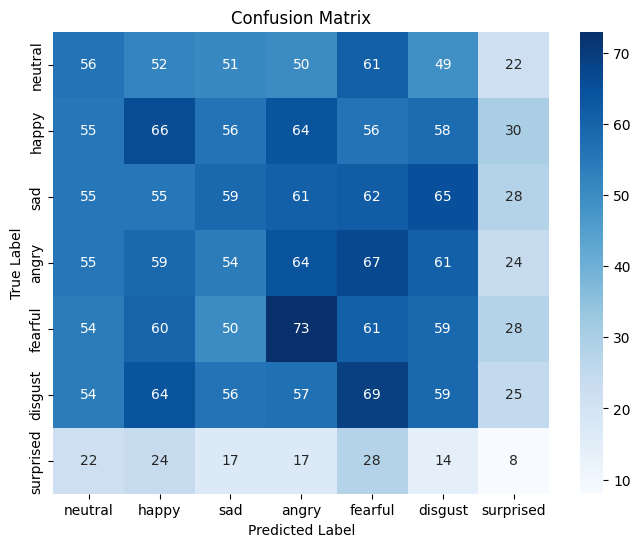

In [281]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define emotion label mappings
emotion_dict = {
    "neutral": 0,
    "happy": 1,
    "sad": 2,
    "angry": 3,
    "fearful": 4,
    "disgust": 5,
    "surprised": 6
}

# Reverse the dictionary to map numbers to emotions
label_names = {v: k for k, v in emotion_dict.items()}

def evaluate_and_plot_results(model, test_loader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient calculations
        for data in test_loader:
            x_batch, y_batch = data
            x_batch = x_batch.to(torch.float32).to(device)
            y_batch = y_batch.to(device)

            y_predictions = model(x_batch)
            _, predicted = torch.max(y_predictions, 1)  # Get predicted class

            all_preds.extend(predicted.cpu().numpy())  # Store predictions
            all_labels.extend(y_batch.cpu().numpy())  # Store actual labels

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Print classification report with emotion labels
    class_report = classification_report(
        all_labels, all_preds, target_names=[label_names[i] for i in range(len(label_names))], digits=4
    )
    print("\nClassification Report:\n", class_report)

    # Plot confusion matrix with emotion labels
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=[label_names[i] for i in range(len(label_names))],
        yticklabels=[label_names[i] for i in range(len(label_names))]
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return cm, class_report  # Return results for further analysis

# Example usage (assuming test_loader and trained model exist):
cm, report = evaluate_and_plot_results(mymodel, test_loader, device)
